### Jolly Seber 

&nbsp;

Jolly-Seber model a statistical method to estimate the size of animal populations based upon mark-recapture data. The process is straight forward. In the first step, a sample of the population is captured and marked with chips or tags. After marking, the captured individuals are released back into the wild. After an interval of time, another sample is taken which may include both previously captured (marked) and new (unmarked) individuals. The model assumes equal capture probability between marked and unmarked so the ratio between marked and unmarked can derive the potential population size. However, the model assumes closed population without migration, birth or death. Many advanced models take into account of individual heterogeneity in capture and survival probabilities and time-varying capture and survival rates. These models can provide more accurate and precise population estimates while addressing the limitations of the basic Jolly-Seber model.

In [1]:
import os
import ast
import pandas as pd
import numpy as np
from pyproj import Proj
import math
import pyodbc
os.chdir('C:/Users/tm/Downloads/utas/WildlifeDatabases')

In [2]:
#coordinates conversion
def convert_easting_northing_to_lat_lon(easting, northing,):
    proj = Proj('+proj=utm +zone=55 +south +ellps=GRS80 +units=m +no_defs')
    lon, lat = proj(easting, northing, inverse=True)
    return lat, lon


### global variables

In [3]:
lonmin=144.165967
latmin=-43.833736
lonmax=148.576978
latmax=-40.349895
lat_centre =-42.10904672752227 ; lon_centre = 146.6417533511285;
gridlen=35

### cleanse

In [4]:
traphist=pd.DataFrame(columns=['ID', 'TrapID', 'DateOfUse', 'Event', 'CaptureType', 'Microchip',
       'Comment'])

traps=pd.DataFrame(columns=['TrapID', 'Northing', 'Easting', 'Comments', 'TrapLine', 'Researcher'])

for i in ['./crabtree/CBT_database_2024_04_CRS.accdb','./franklin/FRA_database_devil_2023_09_CRS.accdb',
         './Woodbridge+Sandfly/Channel_database_devil_2023_11_ER.accdb',
           './arthur river/ARV_database_2023_11_CRES.accdb','./black river/BRI_database_2022_11_KJS.accdb',
         './freycinet/FNP_database_2023_11_CRES.accdb','./takone/TKN_database_2022_12_ACW.accdb',
         './west pencil pine/WPP_Nov_2023_ER.accdb','./wukalina/Wukalina_NOV2020_SN.accdb',
        ]:

    conn = pyodbc.connect(r'Driver={Microsoft Access Driver (*.mdb, *.accdb)};DBQ='+f'{i};')
    
    traps_pending=pd.read_sql('select * from traps',conn)
    traps_pending['site']=i.split('/')[1]
    traps=pd.concat([traps,traps_pending])
    
    traphist_pending=pd.read_sql('select * from traphistory',conn)
    traphist_pending['site']=i.split('/')[1]
    traphist=pd.concat([traphist,traphist_pending])
    
    traps.reset_index(inplace=True,drop=True)
    traphist.reset_index(inplace=True,drop=True)

C:\Users\tm\AppData\Local\Temp\ipykernel_49620\3959596876.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  traps_pending=pd.read_sql('select * from traps',conn)
C:\Users\tm\AppData\Local\Temp\ipykernel_49620\3959596876.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  traphist_pending=pd.read_sql('select * from traphistory',conn)
C:\Users\tm\AppData\Local\Temp\ipykernel_49620\3959596876.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  traps_pending=pd.read_sql('select * from traps',conn)
C:\Users\tm\AppData\Local

In [5]:
#focus on recapture
traphist=traphist[traphist['Event'].isin(['Tasmanian devil','Tasmanian Devil',])].copy()

#remove null microchip
traphist=traphist.loc[traphist['Microchip'].dropna().index]

#remove duplicates
traphist=traphist.loc[traphist[['Microchip','DateOfUse']].drop_duplicates().index]

In [6]:
#sort by date
grande=traphist.merge(traps,on=['TrapID','site'],how='left')
grande.reset_index(inplace=True,drop=True)

#datetimeindex
grande['DateOfUse']=pd.to_datetime(grande['DateOfUse'])

In [7]:
#remove duplicates
grande=grande.loc[grande['Northing'].dropna().index]
grande=grande.loc[grande['Easting'].dropna().index]
grande=grande.loc[grande['Microchip'].dropna().index]
grande=grande.sort_values(['Microchip',"DateOfUse"])
grande.reset_index(inplace=True,drop=True)
grande=grande.loc[grande[['DateOfUse','Microchip']].drop_duplicates().index]

In [8]:
#cleanse coordinates
grande['Northing']=grande['Northing'].str.replace('5224370.09\r\n5224370.09','5224370.09')
grande['Northing']=grande['Northing'].str.replace('0\r\n0','0')
grande['Northing']=grande['Northing'].astype(float)

grande['Easting']=grande['Easting'].str.replace('605373\r\n605373','605373')
grande['Easting']=grande['Easting'].str.replace('0\r\n0','0')
grande['Easting']=grande['Easting'].astype(float)

In [9]:
#for each year,each devil only counts once
grande['year']=grande['DateOfUse'].dt.year
total_raw=grande.loc[grande[['year','Microchip']].drop_duplicates().index]

#sort by year
total_raw=total_raw.sort_values(['year','Microchip'])
total_raw.reset_index(inplace=True,drop=True)

#convert coordinates
total_raw['lat'],total_raw['lon']=convert_easting_northing_to_lat_lon(
    total_raw['Easting'], total_raw['Northing'],)

In [10]:
#assign each coordinate to the grid cell id
lonunit=(lonmax-lonmin)/gridlen
latunit=(latmax-latmin)/gridlen
total_raw['lat num']=(total_raw['lat']-latmin)//latunit
total_raw['lon num']=(total_raw['lon']-lonmin)//lonunit
total_raw['id']=list(zip(total_raw['lat num'].astype(int),total_raw['lon num'].astype(int)))

#remove areas outside of grid cell range
for i in range(len(total_raw)):
    if int(total_raw['id'][i][0])>=gridlen or \
    int(total_raw['id'][i][-1])>=gridlen or \
    int(total_raw['id'][i][0])<0 or int(total_raw['id'][i][-1])<0:
        total_raw.drop(i,inplace=True)

### estimate population size

In [11]:
export_total=pd.DataFrame(columns=['year','population','id'])
for region in total_raw['id'].unique():
    pop_raw=total_raw[total_raw['id']==region].copy()

    #create a dictionary which host last capture and recent capture date
    dic={}
    for i in pop_raw['year'].unique():
        for j in pop_raw['year'].unique():
            if i<j:
                dic[(i,j)]=0

    #find last capture and recent capture date for each individual
    for i in pop_raw['Microchip'].unique():
        subset=pop_raw[pop_raw['Microchip']==i].copy()
        if len(subset)>=2:
            dic[tuple(subset['year'].iloc[:2].tolist())]+=1

    #compute recaptured animals in that year
    total_marked=[sum([dic[j] for j in dic if j[1]==i]) for i in pop_raw['year'].unique()]

    #compute total caught animals in that year
    total_caught=pop_raw.groupby('year').count()['Microchip'].tolist()

    #compute the difference between caught and recaptured
    total_unmarked=[total_caught[i]-total_marked[i] for i in range(len(total_caught))]

    #always release animals caught
    total_released=total_caught

    total_caught_after=[]
    total_recapture=[]
    for i in pop_raw['year'].unique():
        year_before=[j for j in pop_raw['year'].unique() if j<i]
        year_after=[j for j in pop_raw['year'].unique() if j>i]

        #compute the animals caught before that year and recaptured after that year
        total_caught_after.append(sum([dic[(j,k)] for j in year_before for k in year_after]))

        #compute the animals caught that year and recaptured after that year
        total_recapture.append(sum([dic[(i,k)] for k in year_after]))

    #estimate the population
    pop_est=[]
    for i in range(len(total_caught_after)):
        portions_animals_marked=((total_marked[i]+1)/(total_released[i]+1))
        estimated_marked_population=((total_released[i]+1)*total_caught_after[i])/(total_recapture[i]+1)+total_marked[i]
        num=estimated_marked_population/portions_animals_marked
        pop_est.append(num)

    export_region=pd.DataFrame()
    export_region['year']=pop_raw['year'].unique()
    export_region['population']=pop_est
    export_region['id']=str(region)
    export_total=pd.concat([export_region,export_total])

#remove zero
export_total=export_total[export_total['population']!=0]
export_total.reset_index(inplace=True,drop=True)

### disease threshold

In [12]:
#read
os.chdir('C:/Users/tm/Downloads/utas/thesis/chapter1/tasmania/data')
disease=pd.read_csv('disease arrival.csv')

#convert to tuple
disease['id']=disease['id'].apply(lambda x:ast.literal_eval(x))
export_total['id']=export_total['id'].apply(lambda x:ast.literal_eval(x))
export_total['year']=export_total['year'].astype(float)

In [13]:
#get dftd arrival
correction=disease.merge(export_total,on='id',how='right')
correction['dftd']=np.where(correction['year_x']>=correction['year_y'],0,1)

#get northwest
ind1=correction[correction['id'].apply(lambda x:x[1])<=10].index

#get pre dftd based on cunningham et al. 2021
ind2=correction[correction['dftd']==0].index

#get pre disease data
pre_dftd=correction.loc[list(set(ind1).union(ind2))]

In [14]:
#get tasmania land
bioreg=pd.read_csv('bioreg.csv')
bioreg['id']=bioreg['id'].apply(lambda x:ast.literal_eval(x))

In [21]:
zz=pre_dftd.groupby('id').mean()
zz=zz.reset_index()

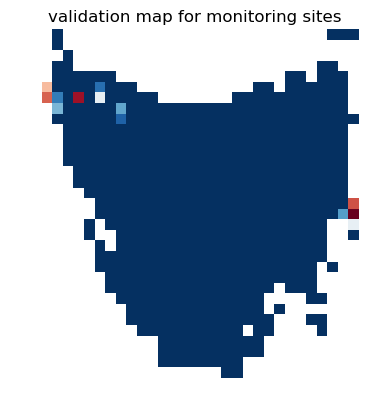

In [24]:
#generate raster
hs=np.zeros((gridlen,gridlen))

for i in bioreg.index:
    hs[bioreg.at[i,'id']]=1
for i in zz.index:
    hs[zz.at[i,'id']]=zz.at[i,'population']
hs=np.flip(hs,axis=0)

hs[hs==0]=np.nan

#viz
import matplotlib.pyplot as plt
plt.imshow(hs,cmap='RdBu_r',vmin=hs[~np.isnan(hs)].min(),
           vmax=hs[~np.isnan(hs)].max())
plt.title('validation map for monitoring sites')
plt.axis('off')
plt.show()

In [16]:
#validation target of monitoring sites
final=pre_dftd[['id','year_y','population']]
final['index']=final['id'].apply(lambda x: (gridlen-1-x[0])*gridlen+x[1])
final.columns=final.columns.str.replace('year_y','year')

C:\Users\tm\AppData\Local\Temp\ipykernel_49620\83024374.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['index']=final['id'].apply(lambda x: (gridlen-1-x[0])*gridlen+x[1])


In [17]:
final[['index', 'year', 'population']].to_csv('C:/Users/tm/Downloads/utas/thesis/chapter1/tasmania/poems/valid_monitor.csv',index=False)